In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from mpl_toolkits import mplot3d




from scipy.special import softmax
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')

In [2]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j]:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        
        
    
    
def make_weighted_adj_estimate(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):
    
    

In [3]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
#print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)


A,B,E =padding(7,1)

print(E)

(312, 312)
[[ 0.15976489 -1.5776325   0.43730083 ... -0.15744554 -1.0588888
   0.9735847 ]
 [-0.8013743  -1.0246376   0.3715572  ... -0.9643986  -1.8675103
   0.43146327]
 [-0.10445411 -0.12540688 -0.8792896  ...  0.61605465 -1.1965704
   1.2727438 ]
 ...
 [ 0.00684965 -1.2439079   0.57352346 ...  0.0172481  -0.4796033
   0.42730567]
 [-0.66157234 -1.5414009   0.32263556 ... -0.4323934  -0.5342357
   1.6439344 ]
 [ 0.3463344   1.0979248  -0.638157   ... -0.12164738 -0.06760365
   0.54393685]]


In [4]:
lenA=[]
for i in range(1,15):

    run=i

    x,y,r,ide,split_id,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    make_true_edgelist(A,run)
    
maxlen=np.max(lenA)
print(maxlen)

312 1
168 2
177 3
294 4
213 5
251 6
213 7
148 8
291 9
254 10
378 11
222 12
174 13
222 14
378


In [5]:
#print(stop)

for i in range(1,15):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    np.savetxt('./'+str(run)+'/'+'embed.txt', b[:,1:])
    
    padding(maxlen,run)
    

(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)
(378, 378)


python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

[ 0.5060553   0.2818542  -0.69770336  0.55112785 -0.5215664   0.2899595
  0.30692217  0.08981479  0.3454369   0.5276049   0.5764146   0.45654616
  0.53778476  0.7512141   0.50152093  0.6800905   1.4122944   1.0762792
  0.34810945  1.2132851  -0.01952898  1.1895902   1.0524558   0.9248265
  0.8069007   1.1831782  -0.36181286 -0.7001086   1.0340841   0.63128483
  0.8963777   0.61909235 -0.875795    0.96744555  0.3229979   0.15670884
 -0.4097579   0.69185066  0.39620966  0.05316508 -0.14512207 -0.43434867
  0.17536272  0.94981736  0.1823784  -0.3916905   0.75083876  0.09866873
 -0.37989447  0.0635443  -0.3500757  -0.7497959   0.8708252   0.45858136
 -0.22649157  0.30947328 -0.15944922 -0.7151233   0.58272016 -0.1113029
  0.04908838 -0.34020835  1.0501322   0.34005475  0.99774885 -0.03723221
 -0.2653867   0.2721236   0.2872238   0.67772686  0.11774658  0.38242364
  0.70718086 -0.00995535  0.42449483  0.46151814  0.09851625  0.35595563
  0.79939675  0.284119    0.34692916  1.0327784   0.394

<IPython.core.display.Javascript object>


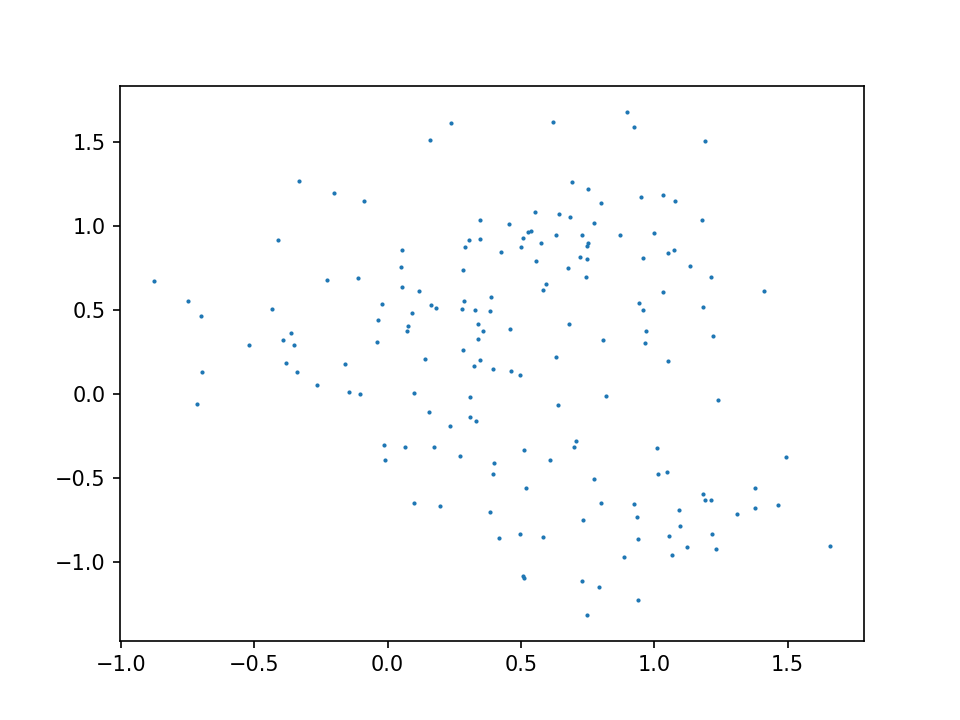

In [6]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


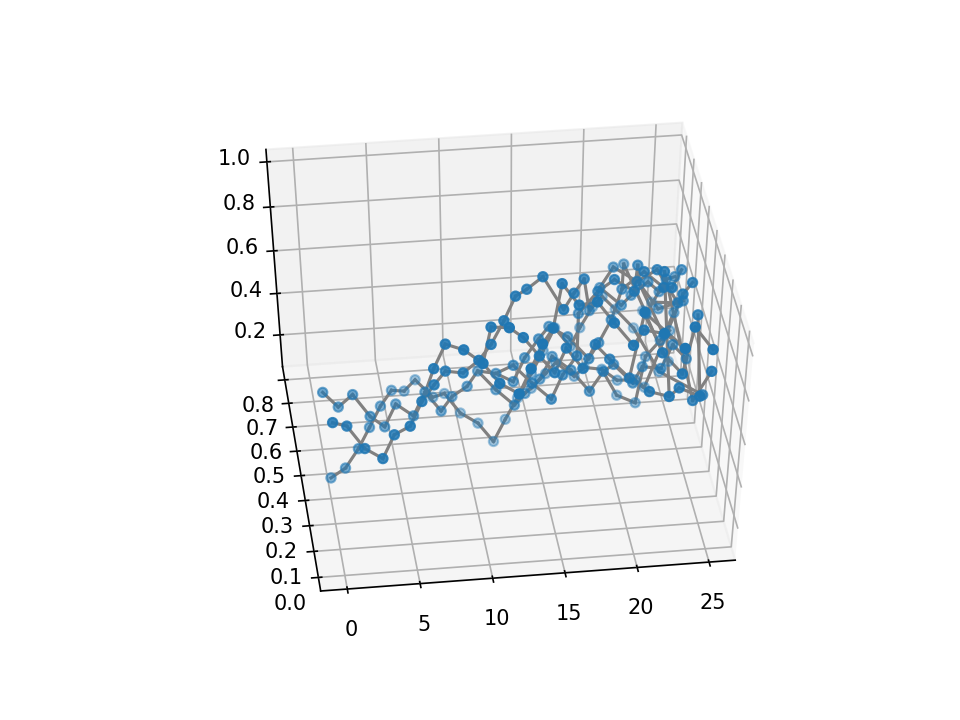

1.0 4.0
[0.19248496993987974, 0.2597557145049167]
2.0 5.0
[0.6542084168336673, 0.5927949040949348]
3.0 6.0
[0.4828657314629258, 0.4129659391191705]
4.0 7.0
[0.2597557145049167, 0.32760233016452256]
5.0 8.0
[0.5927949040949348, 0.5457704727213841]
6.0 9.0
[0.4129659391191705, 0.4818421341968695]
7.0 11.0
[0.32760233016452256, 0.34247211316949105]
8.0 12.0
[0.5457704727213841, 0.5728125785487697]
9.0 10.0
[0.4818421341968695, 0.43289299649088087]
10.0 14.0
[0.43289299649088087, 0.36393951513893813]
11.0 13.0
[0.34247211316949105, 0.35905958444426217]
12.0 15.0
[0.5728125785487697, 0.6002606367524614]
13.0 17.0
[0.35905958444426217, 0.3485228799348812]
14.0 18.0
[0.36393951513893813, 0.3913875733426299]
15.0 16.0
[0.6002606367524614, 0.6655664146008701]
16.0 20.0
[0.6655664146008701, 0.7042499693087686]
17.0 19.0
[0.3485228799348812, 0.2918140795247839]
18.0 21.0
[0.3913875733426299, 0.41010723553794404]
19.0 24.0
[0.2918140795247839, 0.26599619740713987]
20.0 23.0
[0.7042499693087686, 0.

152.0 168.0
[0.4577670267407782, 0.4279066613413949]
153.0 165.0
[0.7548405039613272, 0.8465605131173735]
154.0 169.0
[0.5562514043291781, 0.7187095720270504]
155.0 174.0
[0.5253993327648037, 0.556054501392221]
156.0 164.0
[0.9520334437399871, 0.8977397000562162]
157.0 162.0
[0.6071480755864902, 0.5371484224082588]
158.0 173.0
[0.7740986628004668, 0.7053139523944394]
159.0 161.0
[0.3328062136701103, 0.28764325222800724]
160.0 172.0
[0.8295452209654784, 0.30057614451136033]


In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')

run=13

x,y,r,ide,split_id,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5), unpack=True)

id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    #ax.plot3D(tline, yline, xline, c='red',alpha=w[i]/100)
    ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

blue


/home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


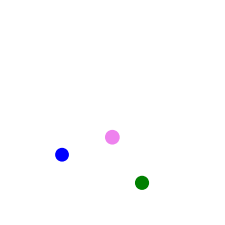

c_full ['blue', 'green', 'violet']


<IPython.core.display.Javascript object>


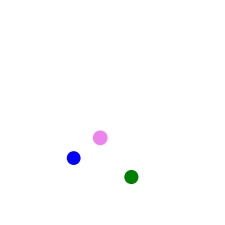

c_full ['blue', 'green', 'violet']
prev_c ['blue' 'green' 'violet']
c ['blue']
prev_c ['blue' 'green' 'violet']
c ['green']
prev_c ['blue' 'green' 'violet']
c ['violet']


<IPython.core.display.Javascript object>


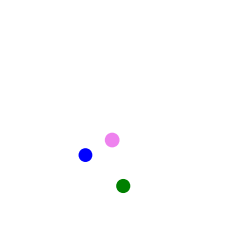

c_full ['blue', 'green', 'violet']
prev_c ['blue' 'green' 'violet']
c ['blue']
prev_c ['blue' 'green' 'violet']
c ['green']
prev_c ['blue' 'green' 'violet']
c ['violet']


<IPython.core.display.Javascript object>


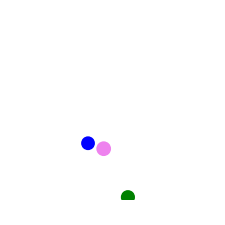

c_full ['blue', 'green', 'violet']
prev_c ['blue' 'green' 'violet']
c ['violet']
prev_c ['blue' 'green' 'violet']
c ['blue']
prev_c ['blue' 'green' 'violet']
c ['green']


<IPython.core.display.Javascript object>


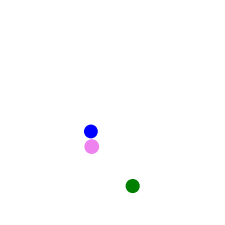

c_full ['violet', 'blue', 'green']
prev_c ['violet' 'blue' 'green']
c ['blue']
prev_c ['violet' 'blue' 'green']
c ['violet']
prev_c ['violet' 'blue' 'green']
c ['green']


<IPython.core.display.Javascript object>


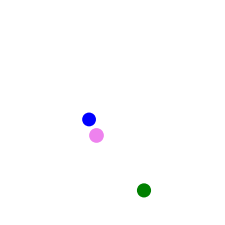

c_full ['blue', 'violet', 'green']
prev_c ['blue' 'violet' 'green']
c ['green']
prev_c ['blue' 'violet' 'green']
c ['blue']
prev_c ['blue' 'violet' 'green']
c ['violet']


<IPython.core.display.Javascript object>


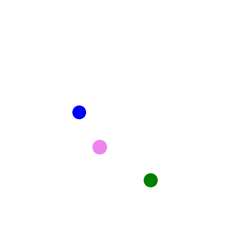

c_full ['green', 'blue', 'violet']
prev_c ['green' 'blue' 'violet']
c ['blue']
prev_c ['green' 'blue' 'violet']
c ['green']
prev_c ['green' 'blue' 'violet']
c ['violet']


<IPython.core.display.Javascript object>


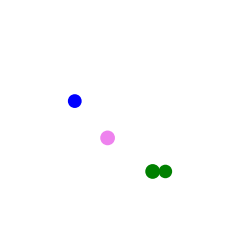

c_full ['blue', 'green', 'violet']
prev_c ['blue' 'green' 'violet']
c ['violet']
prev_c ['blue' 'green' 'violet']
c ['green']
prev_c ['blue' 'green' 'violet']
c ['blue']
prev_c ['blue' 'green' 'violet']
c ['green']


<IPython.core.display.Javascript object>


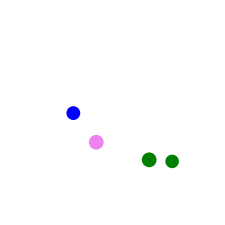

c_full ['violet', 'green', 'blue', 'green']
prev_c ['violet' 'green' 'blue' 'green']
c ['green']
prev_c ['violet' 'green' 'blue' 'green']
c ['blue']
prev_c ['violet' 'green' 'blue' 'green']
c ['green']
prev_c ['violet' 'green' 'blue' 'green']
c ['violet']


<IPython.core.display.Javascript object>


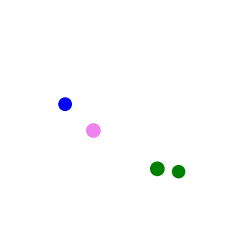

c_full ['green', 'blue', 'green', 'violet']
prev_c ['green' 'blue' 'green' 'violet']
c ['green']
prev_c ['green' 'blue' 'green' 'violet']
c ['violet']
prev_c ['green' 'blue' 'green' 'violet']
c ['green']
prev_c ['green' 'blue' 'green' 'violet']
c ['blue']


<IPython.core.display.Javascript object>


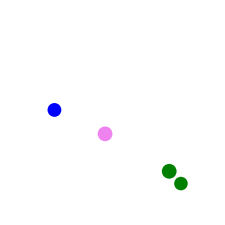

c_full ['green', 'violet', 'green', 'blue']
prev_c ['green' 'violet' 'green' 'blue']
c ['green']
prev_c ['green' 'violet' 'green' 'blue']
c ['violet']
prev_c ['green' 'violet' 'green' 'blue']
c ['blue']
prev_c ['green' 'violet' 'green' 'blue']
c ['green']


<IPython.core.display.Javascript object>


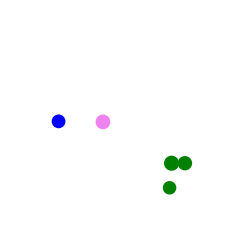

c_full ['green', 'violet', 'blue', 'green']
prev_c ['green' 'violet' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'blue' 'green']
c ['violet']
prev_c ['green' 'violet' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'blue' 'green']
c ['blue']
prev_c ['green' 'violet' 'blue' 'green']
c ['green']


<IPython.core.display.Javascript object>


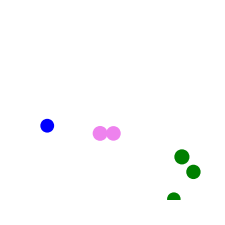

c_full ['green', 'violet', 'green', 'blue', 'green']
prev_c ['green' 'violet' 'green' 'blue' 'green']
c ['blue']
prev_c ['green' 'violet' 'green' 'blue' 'green']
c ['violet']
prev_c ['green' 'violet' 'green' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'green' 'blue' 'green']
c ['violet']
prev_c ['green' 'violet' 'green' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'green' 'blue' 'green']
c ['green']


<IPython.core.display.Javascript object>


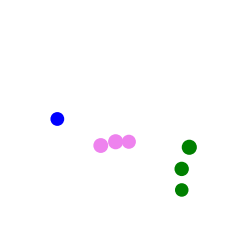

c_full ['blue', 'violet', 'green', 'violet', 'green', 'green']
prev_c ['blue' 'violet' 'green' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'violet' 'green' 'violet' 'green' 'green']
c ['blue']
prev_c ['blue' 'violet' 'green' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'violet' 'green' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'violet' 'green' 'violet' 'green' 'green']
c ['green']
prev_c ['blue' 'violet' 'green' 'violet' 'green' 'green']
c ['green']
prev_c ['blue' 'violet' 'green' 'violet' 'green' 'green']
c ['green']


<IPython.core.display.Javascript object>


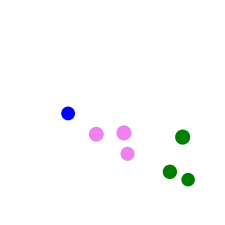

c_full ['violet', 'blue', 'violet', 'violet', 'green', 'green', 'green']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'green' 'green']
c ['green']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'green' 'green']
c ['green']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'green' 'green']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'green' 'green']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'green' 'green']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'green' 'green']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'green' 'green']
c ['green']


<IPython.core.display.Javascript object>


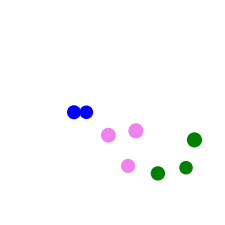

c_full ['green', 'green', 'violet', 'blue', 'violet', 'violet', 'green']
prev_c ['green' 'green' 'violet' 'blue' 'violet' 'violet' 'green']
c ['blue']
prev_c ['green' 'green' 'violet' 'blue' 'violet' 'violet' 'green']
c ['violet']
prev_c ['green' 'green' 'violet' 'blue' 'violet' 'violet' 'green']
c ['green']
prev_c ['green' 'green' 'violet' 'blue' 'violet' 'violet' 'green']
c ['violet']
prev_c ['green' 'green' 'violet' 'blue' 'violet' 'violet' 'green']
c ['blue']
prev_c ['green' 'green' 'violet' 'blue' 'violet' 'violet' 'green']
c ['green']
prev_c ['green' 'green' 'violet' 'blue' 'violet' 'violet' 'green']
c ['green']
prev_c ['green' 'green' 'violet' 'blue' 'violet' 'violet' 'green']
c ['violet']


<IPython.core.display.Javascript object>


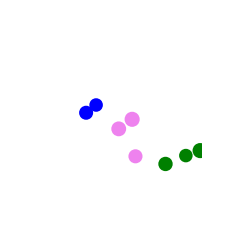

c_full ['blue', 'violet', 'green', 'violet', 'blue', 'green', 'green', 'violet']
prev_c ['blue' 'violet' 'green' 'violet' 'blue' 'green' 'green' 'violet']
c ['green']
prev_c ['blue' 'violet' 'green' 'violet' 'blue' 'green' 'green' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'green' 'violet' 'blue' 'green' 'green' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'green' 'violet' 'blue' 'green' 'green' 'violet']
c ['green']
prev_c ['blue' 'violet' 'green' 'violet' 'blue' 'green' 'green' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'green' 'violet' 'blue' 'green' 'green' 'violet']
c ['violet']
prev_c ['blue' 'violet' 'green' 'violet' 'blue' 'green' 'green' 'violet']
c ['blue']
prev_c ['blue' 'violet' 'green' 'violet' 'blue' 'green' 'green' 'violet']
c ['green']


<IPython.core.display.Javascript object>


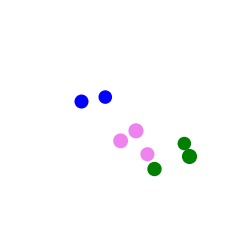

c_full ['green', 'violet', 'violet', 'green', 'blue', 'violet', 'blue', 'green']
prev_c ['green' 'violet' 'violet' 'green' 'blue' 'violet' 'blue' 'green']
c ['violet']
prev_c ['green' 'violet' 'violet' 'green' 'blue' 'violet' 'blue' 'green']
c ['blue']
prev_c ['green' 'violet' 'violet' 'green' 'blue' 'violet' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'violet' 'green' 'blue' 'violet' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'violet' 'green' 'blue' 'violet' 'blue' 'green']
c ['green']
prev_c ['green' 'violet' 'violet' 'green' 'blue' 'violet' 'blue' 'green']
c ['blue']
prev_c ['green' 'violet' 'violet' 'green' 'blue' 'violet' 'blue' 'green']
c ['violet']
prev_c ['green' 'violet' 'violet' 'green' 'blue' 'violet' 'blue' 'green']
c ['violet']


<IPython.core.display.Javascript object>


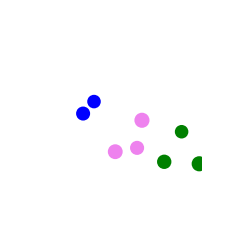

c_full ['violet', 'blue', 'green', 'green', 'green', 'blue', 'violet', 'violet']
prev_c ['violet' 'blue' 'green' 'green' 'green' 'blue' 'violet' 'violet']
c ['green']
prev_c ['violet' 'blue' 'green' 'green' 'green' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'green' 'green' 'green' 'blue' 'violet' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'green' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'green' 'green' 'green' 'blue' 'violet' 'violet']
c ['blue']
prev_c ['violet' 'blue' 'green' 'green' 'green' 'blue' 'violet' 'violet']
c ['green']
prev_c ['violet' 'blue' 'green' 'green' 'green' 'blue' 'violet' 'violet']
c ['violet']
prev_c ['violet' 'blue' 'green' 'green' 'green' 'blue' 'violet' 'violet']
c ['green']


<IPython.core.display.Javascript object>


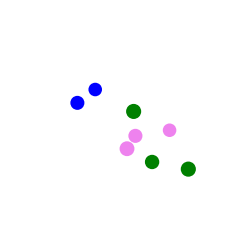

c_full ['green', 'violet', 'blue', 'violet', 'blue', 'green', 'violet', 'green']
prev_c ['green' 'violet' 'blue' 'violet' 'blue' 'green' 'violet' 'green']
c ['violet']
prev_c ['green' 'violet' 'blue' 'violet' 'blue' 'green' 'violet' 'green']
c ['blue']
prev_c ['green' 'violet' 'blue' 'violet' 'blue' 'green' 'violet' 'green']
c ['violet']
prev_c ['green' 'violet' 'blue' 'violet' 'blue' 'green' 'violet' 'green']
c ['violet']
prev_c ['green' 'violet' 'blue' 'violet' 'blue' 'green' 'violet' 'green']
c ['green']
prev_c ['green' 'violet' 'blue' 'violet' 'blue' 'green' 'violet' 'green']
c ['blue']
prev_c ['green' 'violet' 'blue' 'violet' 'blue' 'green' 'violet' 'green']
c ['green']
prev_c ['green' 'violet' 'blue' 'violet' 'blue' 'green' 'violet' 'green']
c ['green']


<IPython.core.display.Javascript object>


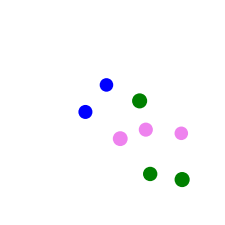

c_full ['violet', 'blue', 'violet', 'violet', 'green', 'blue', 'green', 'green']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'blue' 'green' 'green']
c ['green']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'blue' 'green' 'green']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'blue' 'green' 'green']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'blue' 'green' 'green']
c ['blue']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'blue' 'green' 'green']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'blue' 'green' 'green']
c ['green']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'blue' 'green' 'green']
c ['violet']
prev_c ['violet' 'blue' 'violet' 'violet' 'green' 'blue' 'green' 'green']
c ['green']


<IPython.core.display.Javascript object>


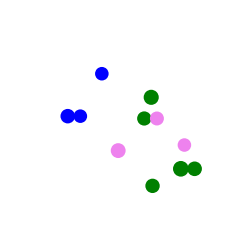

c_full ['green', 'blue', 'violet', 'blue', 'violet', 'green', 'violet', 'green']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['green']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['green']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['blue']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['violet']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['green']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['violet']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['blue']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['green']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['blue']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'violet' 'green']
c ['green']
prev_c ['green' 'blue' 'violet' 'blue' 'violet' 'green' 'vio

<IPython.core.display.Javascript object>


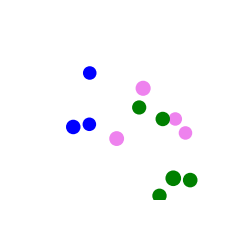

c_full ['green', 'green', 'blue', 'violet', 'green', 'violet', 'blue', 'green', 'blue', 'green', 'violet']
prev_c ['green' 'green' 'blue' 'violet' 'green' 'violet' 'blue' 'green' 'blue'
 'green' 'violet']
c ['violet']
prev_c ['green' 'green' 'blue' 'violet' 'green' 'violet' 'blue' 'green' 'blue'
 'green' 'violet']
c ['green']
prev_c ['green' 'green' 'blue' 'violet' 'green' 'violet' 'blue' 'green' 'blue'
 'green' 'violet']
c ['green']
prev_c ['green' 'green' 'blue' 'violet' 'green' 'violet' 'blue' 'green' 'blue'
 'green' 'violet']
c ['blue']
prev_c ['green' 'green' 'blue' 'violet' 'green' 'violet' 'blue' 'green' 'blue'
 'green' 'violet']
c ['green']
prev_c ['green' 'green' 'blue' 'violet' 'green' 'violet' 'blue' 'green' 'blue'
 'green' 'violet']
c ['violet']
prev_c ['green' 'green' 'blue' 'violet' 'green' 'violet' 'blue' 'green' 'blue'
 'green' 'violet']
c ['green']
prev_c ['green' 'green' 'blue' 'violet' 'green' 'violet' 'blue' 'green' 'blue'
 'green' 'violet']
c ['violet']
prev_c ['gr

<IPython.core.display.Javascript object>


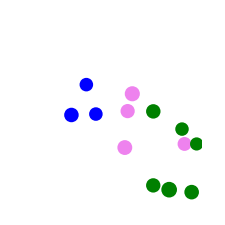

c_full ['violet', 'green', 'green', 'blue', 'green', 'violet', 'green', 'violet', 'blue', 'blue', 'violet', 'green']
prev_c ['violet' 'green' 'green' 'blue' 'green' 'violet' 'green' 'violet' 'blue'
 'blue' 'violet' 'green']
c ['blue']
prev_c ['violet' 'green' 'green' 'blue' 'green' 'violet' 'green' 'violet' 'blue'
 'blue' 'violet' 'green']
c ['blue']
prev_c ['violet' 'green' 'green' 'blue' 'green' 'violet' 'green' 'violet' 'blue'
 'blue' 'violet' 'green']
c ['violet']
prev_c ['violet' 'green' 'green' 'blue' 'green' 'violet' 'green' 'violet' 'blue'
 'blue' 'violet' 'green']
c ['violet']
prev_c ['violet' 'green' 'green' 'blue' 'green' 'violet' 'green' 'violet' 'blue'
 'blue' 'violet' 'green']
c ['green']
prev_c ['violet' 'green' 'green' 'blue' 'green' 'violet' 'green' 'violet' 'blue'
 'blue' 'violet' 'green']
c ['green']
prev_c ['violet' 'green' 'green' 'blue' 'green' 'violet' 'green' 'violet' 'blue'
 'blue' 'violet' 'green']
c ['violet']
prev_c ['violet' 'green' 'green' 'blue' 'green' '

<IPython.core.display.Javascript object>


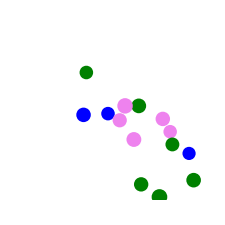

c_full ['blue', 'blue', 'violet', 'violet', 'green', 'green', 'violet', 'green', 'blue', 'green', 'green', 'violet', 'green']
prev_c ['blue' 'blue' 'violet' 'violet' 'green' 'green' 'violet' 'green' 'blue'
 'green' 'green' 'violet' 'green']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'violet' 'green' 'green' 'violet' 'green' 'blue'
 'green' 'green' 'violet' 'green']
c ['green']
prev_c ['blue' 'blue' 'violet' 'violet' 'green' 'green' 'violet' 'green' 'blue'
 'green' 'green' 'violet' 'green']
c ['violet']
prev_c ['blue' 'blue' 'violet' 'violet' 'green' 'green' 'violet' 'green' 'blue'
 'green' 'green' 'violet' 'green']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'violet' 'green' 'green' 'violet' 'green' 'blue'
 'green' 'green' 'violet' 'green']
c ['green']
prev_c ['blue' 'blue' 'violet' 'violet' 'green' 'green' 'violet' 'green' 'blue'
 'green' 'green' 'violet' 'green']
c ['blue']
prev_c ['blue' 'blue' 'violet' 'violet' 'green' 'green' 'violet' 'green' 'blue'
 'green' 'green' 'violet' 'green']

<IPython.core.display.Javascript object>


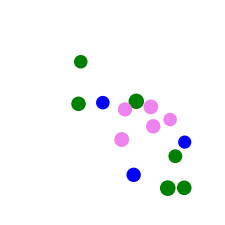

c_full ['blue', 'green', 'violet', 'blue', 'green', 'blue', 'green', 'violet', 'violet', 'green', 'violet', 'violet', 'green', 'green']
prev_c ['blue' 'green' 'violet' 'blue' 'green' 'blue' 'green' 'violet' 'violet'
 'green' 'violet' 'violet' 'green' 'green']
c ['green']
prev_c ['blue' 'green' 'violet' 'blue' 'green' 'blue' 'green' 'violet' 'violet'
 'green' 'violet' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'green' 'violet' 'blue' 'green' 'blue' 'green' 'violet' 'violet'
 'green' 'violet' 'violet' 'green' 'green']
c ['violet']
prev_c ['blue' 'green' 'violet' 'blue' 'green' 'blue' 'green' 'violet' 'violet'
 'green' 'violet' 'violet' 'green' 'green']
c ['green']
prev_c ['blue' 'green' 'violet' 'blue' 'green' 'blue' 'green' 'violet' 'violet'
 'green' 'violet' 'violet' 'green' 'green']
c ['green']
prev_c ['blue' 'green' 'violet' 'blue' 'green' 'blue' 'green' 'violet' 'violet'
 'green' 'violet' 'violet' 'green' 'green']
c ['blue']
prev_c ['blue' 'green' 'violet' 'blue' 'green' 

In [39]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        return prev_c[int(ii-1)]
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0]
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id_f=[1,2,3]


print(c[id_f==1])


    


for t in range(26):
    
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
        ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

In [9]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)

0 [array([], dtype=float64)]
1 [array([0.58927856, 0.65799199, 0.64355315, 0.70932325, 0.77052407,
       0.78193128, 0.85193093, 0.79963646, 0.85134088, 0.84649701,
       0.7880353 , 0.82708538, 0.7636801 , 0.80803438, 0.8031905 ,
       0.80847392, 0.81199807, 0.78253689, 0.80794463, 0.7455043 ,
       0.79317789, 0.76252272, 0.79118204, 0.85059466, 0.79287049,
       0.77843164])]
2 [array([0.46482966, 0.39525409, 0.42107197, 0.37307662, 0.42170975,
       0.36526044, 0.43351938, 0.46997208])]
3 [array([0.30250501, 0.28293755, 0.30419117, 0.25045806, 0.19151622,
       0.13119038, 0.07802641, 0.1402663 , 0.18696334, 0.22074787,
       0.17742428, 0.23925588])]
4 [array([0.47960755, 0.54766572, 0.47871224, 0.43643478, 0.4860101 ,
       0.55315765, 0.59751193, 0.54762646, 0.6065683 , 0.61316904])]
5 [array([0.56010755, 0.55878551, 0.51650805, 0.44855431, 0.397148  ,
       0.44184234, 0.37563137, 0.43826967, 0.42556013, 0.46748551,
       0.42807044, 0.36056132, 0.32006075, 0.389935